In [21]:
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict, KFold
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
import pandas as pd
from PIL import Image
import requests

import keras
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential, load_model

from src.read_data import read_data
from src.train import train
from src.validate import validate
from src.init_model import create_seed_model
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The problem and the data

The problem is to classify images of hand-written digits. The below plot illustrates the data.  The data has been reshaped and scaled to work as input to Keras/Tensorflow, this is handled internally by 'read_data'.

In [2]:
training_data = '/home/jovyan/dataset/mnist/train.csv'
(x_train, y_train, classes) = read_data(training_data)

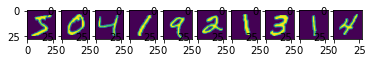

In [3]:
imgs = range(10)
for i,img in enumerate(imgs): 
    pylab.subplot(1, len(imgs), i+1)
    pylab.imshow(x_train[img][:,:,0])

## Create a seed model

We will in this example use a Convolutional Neural Network (CNN) trained on the MNIST dataset. This example is often seen as the "Hello World" of deep learning. 

In [4]:
model = create_seed_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

## Train the model

We are now ready to use the model staged in the Minio storage to train a first version of the model. We here train one epoch over the entire 60000 examples in the training dataset.

In [5]:
model_v1 = train(model,training_data,sample_fraction=1)

-- RUNNING TRAINING --
Epoch 1/1
60000/60000 [==============================] - 400s 7ms/step - loss: 0.1845 - accuracy: 0.9441
-- TRAINING COMPLETED --


## Generate metrics

We next need to evaluate the model. We use the test set - images that have not been used in the training phase - to compute various metrics. In this case, we compute a classification report and the test loss and test accuracy.

In [6]:
test_data = '/home/jovyan/dataset/mnist/test.csv'
report = validate(model_v1,test_data,sample_fraction=0.1)

Training loss: 0.08943096736073494
Training accuracy: 0.972000002861023


The process of evaluating a model is a reccuring task when new model versions and model deployments are generated. To help with automation of this task, STACKn has support for creating and defining report generators than can be run as Kubernetes Jobs from outside the Labs context. We will revisit this in the context of automated validation workflows in a future tutorial. 

## Save and publish the model to Studio

We can now use the STACKn CLI to publish the model to Studio to prepare it 
for deployment. Note that this creates a snapshot of this model, and copies the model .h5 file to read_only Minio storage. If you at a later stage alters the copy in your work folder and want these changes reflected in the published or deployed model, you need to either delete the model and post a new one, or publish a new updated version of the model. STACKn supports flexible tagging of models and deployments so that you can implement a versioning scheme of your chosing. Here, we will use semantic versioning. 

#### We first serialize the Keras model to the working directory

In [7]:
model_name = 'digits-clf'
tag = 'v1'

In [9]:
model.save('models/{}/tags/{}/{}_v1.h5'.format(model_name,tag,model_name))

We also save the report we generated

In [10]:
import json
with open('models/{}/tags/{}/reports/report.json'.format(model_name,tag),'w') as fh:
    fh.write(json.dumps(report))

#### We next invoke the STACKn CLI to publish the model to Studio. 

A model published to Studio is a bundle consisting of the raw model binary and a helper file that is used for deployments. The helper file is responsible for loading the model from disk. There is an example helper.py in the root of the work directory. We copy that file to the working directory for the model version and create a tarball. 

In [20]:
import os
import shutil
from scaleout.studioclient import StudioClient
client = StudioClient()

In [211]:
shutil.copyfile('helpers.py', 'models/digits-clf/tags/v1/helpers.py')
shutil.copyfile('mnist.py', 'models/digits-clf/tags/v1/mnist.py')
shutil.copyfile('requirements.txt', 'models/digits-clf/tags/v1/requirements.txt')
os.chdir('models/digits-clf/tags/v1')
os.system('tar czvf digits-clf_v1.tar.gz .')
os.chdir('../../../..')

Now we are ready to publish the model:

In [212]:
!stackn create model -n mnist -t v1 -m models/digits-clf/tags/v1/digits-clf_v1.tar.gz

Created model: mnist, tag: v1


You can now head over to the 'Models' page in Studio to view your published model. If you click on the model name you will see an expanded view with metadata, active deployments and reports. Note the README.md tab - this is your model's 'model card'. This is where you can add rich annotations to your model (this will later be displayed to end-consumers of the model when the model is made public). 

## Deploy the model as a microservice with a REST prediction API

In [213]:
!stackn create deployment -m mnist -t v1 -d py37

starting build...
http://studio.k8s-prod.pharmb.io/api/deploymentInstances/build_instance/
ok
200
ok
Created deployment: mnist


## Evaulate the deployed model against test data

In [102]:
!stackn get deployments

+-----------+-----+----------------------------------------+
|    Name   | Tag |                Endpoint                |
+-----------+-----+----------------------------------------+
| testmodel |  v1 | testmodel-v1.studio.k8s-prod.pharmb.io |
|  amlmodel |  v1 | amlmodel-v1.studio.k8s-prod.pharmb.io  |
|   mnist   |  v1 |   mnist-v1.studio.k8s-prod.pharmb.io   |
+-----------+-----+----------------------------------------+


In [103]:
endpoint = 'https://mnist-v1.studio.k8s-prod.pharmb.io/predict'

In [214]:
img_ind = 120

In [223]:
(x_test, y_test, testclasses) = read_data('/home/jovyan/dataset/mnist/test.csv')

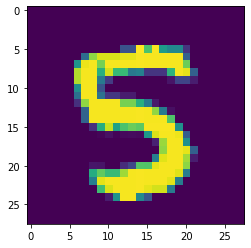

In [224]:
pylab.imshow(x_test[img_ind][:,:,0])

In [225]:
r = requests.post(endpoint, headers=client.auth_headers, json={'input': np.array([x_test[img_ind]]).tolist()})

In [226]:
r.text

'{"prediction": 5}'

In [152]:
from PIL import Image
im = Image.fromarray((255*x_train[img_ind][:,:,0]).astype(uint8))
im.save("test.png")

In [219]:
from scaleout.studioclient import StudioClient
client = StudioClient()

In [220]:
client.project_slug

'mnist-hnl'